# ▶ Ejercicio 9. Frecuentistas vs Bayesianos

Supongamos que medimos el tiempo de decaimiento $t$ de una partícula,
modelado con una distribución exponencial con parámetro (tasa) $\lambda$:

$$
p(t \mid \lambda) = \lambda e^{-\lambda t}, \quad t \ge 0.
$$

En este ejercicio vamos a:

- Simular $N = 50$ mediciones del tiempo de decaimiento.
- Estimar $\lambda$ con el estimador de Maximun Likelihood (enfoque frecuentista).
- Estimar $\lambda$ con inferencia Bayesiana asumiendo un prior plano.
- Comparar ambas estimaciones.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Para reproducibilidad
np.random.seed(42)

# Parámetro verdadero de la distribución exponencial
# (tasa de decaimiento "real" de la partícula)
lambda_true = 0.5   # por ejemplo, 0.5 1/unidad de tiempo

# Número de mediciones
N = 50

# Recordatorio:
# Si t ~ Exp(λ), en NumPy se usa scale = 1/λ
tiempos = np.random.exponential(scale=1/lambda_true, size=N)

print("Primeros 10 tiempos simulados:")
print(tiempos[:10])
print(f"\nMedia muestral = {tiempos.mean():.3f}")


Primeros 10 tiempos simulados:
[0.93853618 6.02024286 2.63349139 1.82588511 0.33924974 0.33919258
 0.11967754 4.02246173 1.83816431 2.46250012]

Media muestral = 1.692


## 1) Estimador de Maximum Likelihood (frecuentista)

Dada la muestra $t_1, \dots, t_N$ con modelo exponencial,

$$
L(\lambda)
= \prod_{i=1}^N \lambda e^{-\lambda t_i}
= \lambda^N \exp\left(-\lambda \sum_{i=1}^N t_i\right).
$$

La log-likelihood es

$$
\ln L(\lambda) = N \ln \lambda - \lambda \sum_{i=1}^N t_i.
$$

Derivando y haciendo cero:

$$
\frac{d}{d\lambda} \ln L(\lambda)
= \frac{N}{\lambda} - \sum_{i=1}^N t_i = 0
\quad \Rightarrow \quad
\hat\lambda_{\text{ML}} = \frac{N}{\sum_{i=1}^N t_i}
= \frac{1}{\bar t}.
$$

Este es el estimador frecuentista para $\lambda$.


In [3]:
# Estimador de Maximum Likelihood:
lambda_ML = N / tiempos.sum()    # equivalente a 1 / tiempos.mean()

print(f"λ verdadero        = {lambda_true:.4f}")
print(f"λ_ML (frecuentista) = {lambda_ML:.4f}")


λ verdadero        = 0.5000
λ_ML (frecuentista) = 0.5911


## 2) Enfoque Bayesiano con prior plano

Usamos el mismo modelo:

$$
p(t_i \mid \lambda) = \lambda e^{-\lambda t_i}, \quad t_i \ge 0.
$$

Tomamos un prior plano para $\lambda$:

$$
p(\lambda) \propto 1, \quad \lambda > 0.
$$

Entonces la posterior es proporcional a

$$
p(\lambda \mid \{t_i\}) \propto L(\lambda)p(\lambda)
\propto \lambda^N \exp\left(-\lambda \sum_{i=1}^N t_i\right),
$$

que es una distribución Gamma con parámetros

$$
\alpha = N + 1, \qquad \beta = \sum_{i=1}^N t_i,
$$

(usando la convención $p(\lambda) \propto \lambda^{\alpha - 1} e^{-\beta \lambda}$).

De aquí:

- Media posterior:
  $$\mathbb{E}[\lambda \mid \text{datos}] = \dfrac{\alpha}{\beta}
  = \dfrac{N+1}{\sum t_i}.$$

- Moda posterior (para $\alpha > 1$):
  $$\lambda_{\text{MAP}} = \dfrac{\alpha - 1}{\beta}
  = \dfrac{N}{\sum t_i} = \hat\lambda_{\text{ML}}.$$

Es decir:

- La moda Bayesiana con prior plano coincide con el estimador ML.
- La media Bayesiana es muy cercana a ML cuando $N$ es grande.



In [4]:
from math import gamma

# Parámetros de la posterior Gamma(α, β) con prior plano
alpha_post = N + 1
beta_post = tiempos.sum()  # parámetro "rate"

# Media y moda de la posterior
lambda_Bayes_mean = alpha_post / beta_post
lambda_Bayes_MAP = (alpha_post - 1) / beta_post  # coincide con λ_ML

# Muestreo de la posterior para intervalos creíbles
samples = np.random.gamma(shape=alpha_post, scale=1/beta_post, size=100_000)
low, high = np.percentile(samples, [2.5, 97.5])

print(f"λ verdadero                 = {lambda_true:.4f}")
print(f"λ_ML (frecuentista)         = {lambda_ML:.4f}")
print(f"λ_MAP (Bayes, prior plano)  = {lambda_Bayes_MAP:.4f}")
print(f"Media posterior (Bayes)     = {lambda_Bayes_mean:.4f}")
print(f"IC Bayes 95% (aprox)        = [{low:.4f} , {high:.4f}]")


λ verdadero                 = 0.5000
λ_ML (frecuentista)         = 0.5911
λ_MAP (Bayes, prior plano)  = 0.5911
Media posterior (Bayes)     = 0.6029
IC Bayes 95% (aprox)        = [0.4492 , 0.7795]


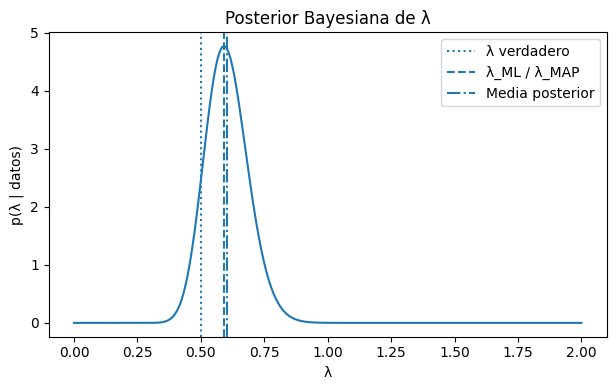

In [5]:
plt.figure(figsize=(12,4))

# Posterior de λ
plt.subplot(1,2,2)
lam_grid = np.linspace(0, 2.0, 400)
posterior_pdf = (beta_post**alpha_post / gamma(alpha_post)) * \
                (lam_grid**(alpha_post-1)) * np.exp(-beta_post * lam_grid)

plt.plot(lam_grid, posterior_pdf)
plt.axvline(lambda_true, linestyle=":", label="λ verdadero")
plt.axvline(lambda_ML, linestyle="--", label="λ_ML / λ_MAP")
plt.axvline(lambda_Bayes_mean, linestyle="-.", label="Media posterior")
plt.xlabel("λ")
plt.ylabel("p(λ | datos)")
plt.title("Posterior Bayesiana de λ")
plt.legend()

plt.tight_layout()
plt.show()


## 3) Comparación entre las dos estimaciones

- Frecuentista:
  - El estimador de Maximum Likelihood es
    $\hat\lambda_{\text{ML}} = N / \sum t_i = 1 / \bar t$.
  - Es un estimador puntual, su incertidumbre se estudia a partir
    de la distribución muestral (por ejemplo usando varianzas asintóticas).

- Bayesiano (prior plano):
  - La posterior de $\lambda$ es Gamma$(N+1, \sum t_i)$.
  - La moda de la posterior (MAP) coincide exactamente con $\hat\lambda_{\text{ML}}$.
  - La media posterior es $(N+1)/\sum t_i$, muy cercana a ML para $N$ grande.
  - Además proporciona un intervalo creíble directo para $\lambda$.

En este caso, con un prior no informativo y $N=50$, ambos enfoques dan
valores muy similares de $\lambda$, pero el enfoque Bayesiano entrega
explícitamente la distribución completa de incertidumbre.
